# Plotting citation trajectories
What do the citation trajectories of research papers look like?  
Similar to researchtrends.ai  



In [1]:
from queries import *
from datetime import date
import matplotlib.pyplot as plt
import numpy as np

from plotting_citation_trajectories import plot_citation_trajectory

In [2]:
target_corpus_id = 201646309

query = 'select citing_corpus_ids from papers where corpus_id = :target_corpus_id'
citing_cids = sql_execute(query, target_corpus_id=target_corpus_id)[0][0]

query = 'select corpus_id from papers'
exisiting_corpus_ids = sql_execute(query)
existing_corpus_ids = [cid[0] for cid in exisiting_corpus_ids]

citing_cids = set(citing_cids).intersection(set(existing_corpus_ids))
list(citing_cids)[:5]

[263864320, 266149890, 237420548, 260775941, 259244038]

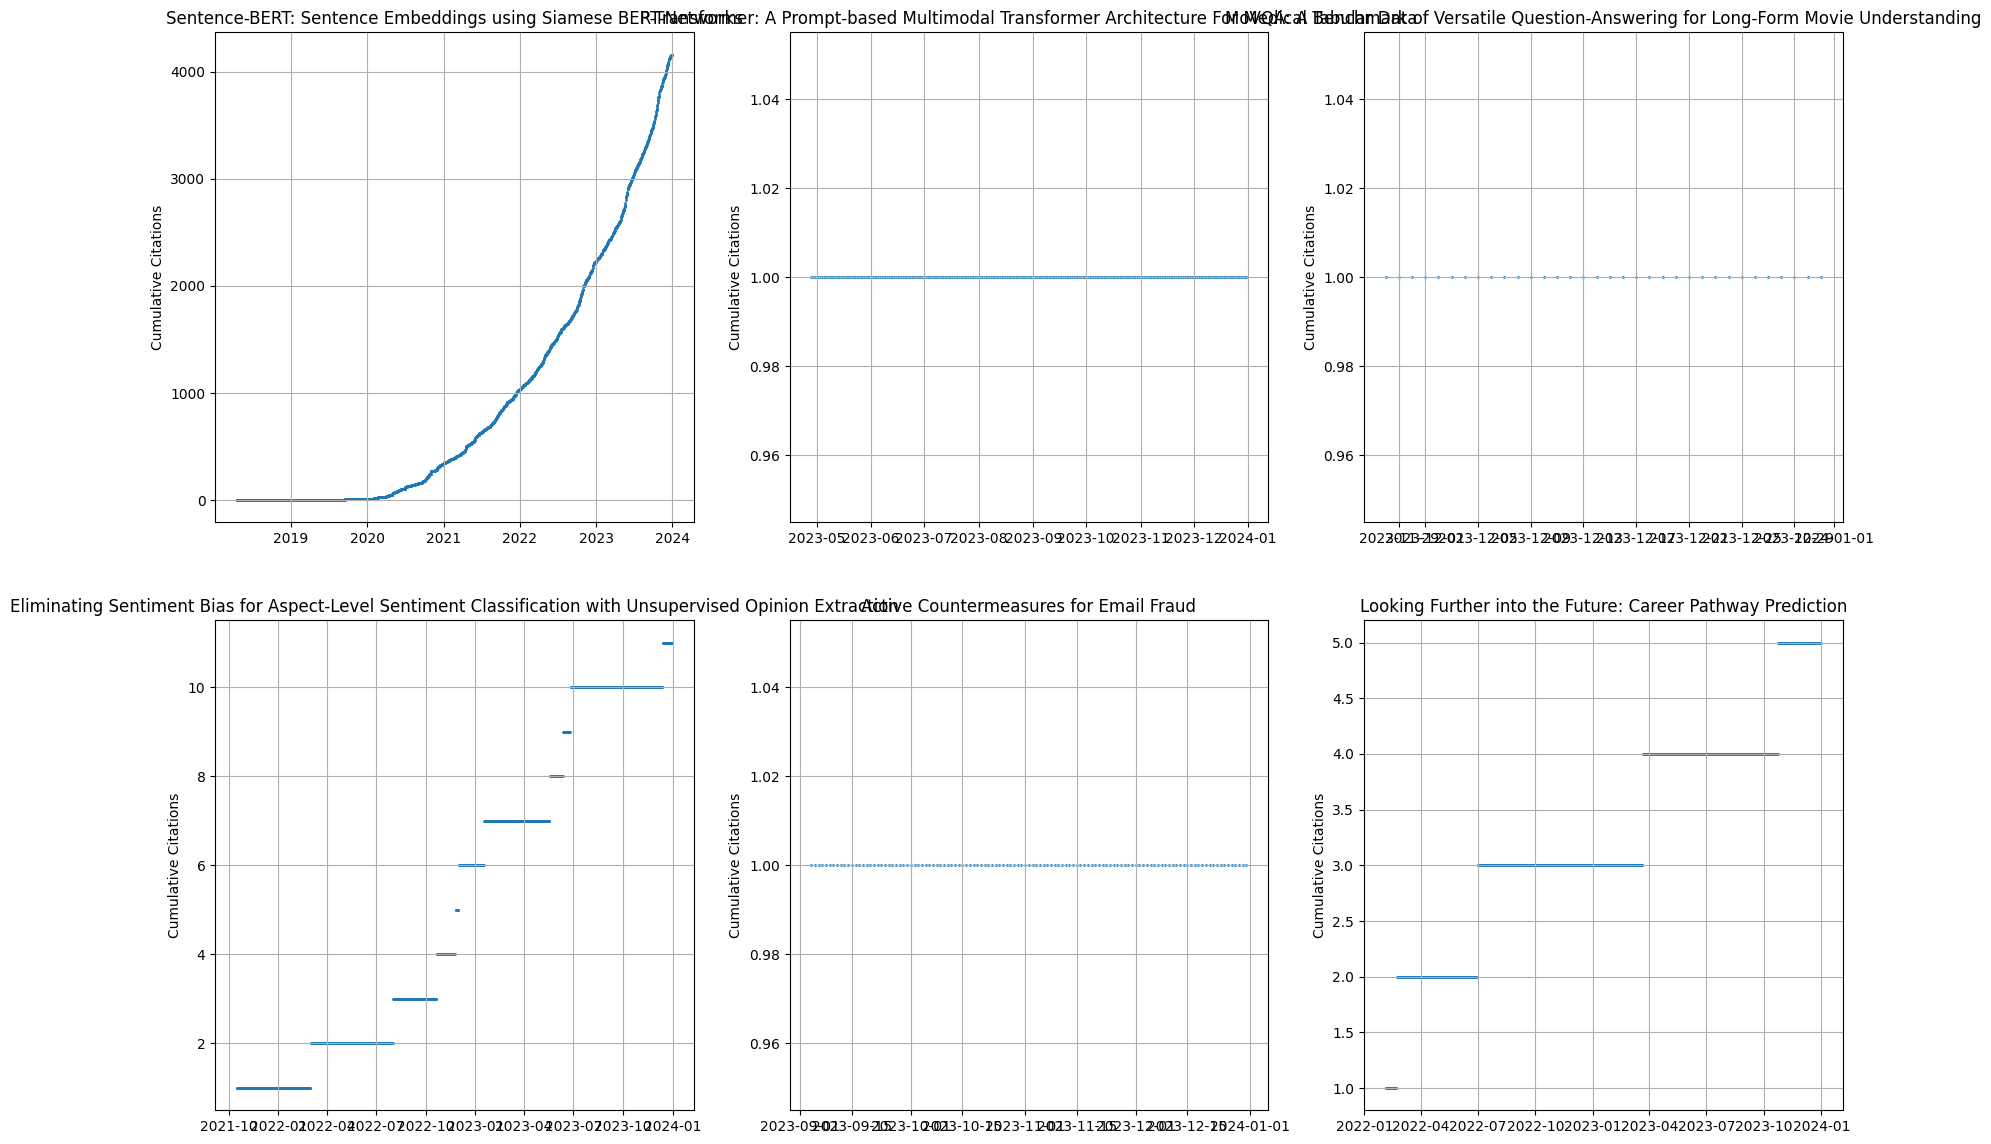

In [3]:

fig, ax = plt.subplots(2,3, figsize=(21, 14))
plot_citation_trajectory(ax[0,0], target_corpus_id)
plot_citation_trajectory(ax[0,1], 263864320)
plot_citation_trajectory(ax[0,2], 266149890)
plot_citation_trajectory(ax[1,0], 237420548)
plot_citation_trajectory(ax[1,1], 253157400)
plot_citation_trajectory(ax[1,2], 247128095)

### Predicting future citations based on historic citations
With such regular curves as for SentenceBERT, surely we can trivially extrapolate citation numbers.  
But what is the best citation trend prediction model?  

I want to find the best model here, to use that for my new citations prediction model.  

Training set cutoff: 2024
Test set period: 2024 - 2025

### Autoregressive integrated moving average (ARIMA)
Old school technique used for modelling (cycling) timeseries  
https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average

In [4]:
from plotting_citation_trajectories import get_citation_plot_data, train_set_max_date
import numpy as np
transform = np.sqrt

title, citing_dates, cumulative_citations = get_citation_plot_data(target_corpus_id, data_transform=transform)
_, test_set_timeseries_index, test_set_timeseries_data = get_citation_plot_data(target_corpus_id, test_set=True, data_transform=transform)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")

# 1. Generate some sample time series data
# In a real scenario, you would load your data from a CSV, database, etc.
# Let's create a simple time series with a trend and some seasonality
dates = citing_dates
data = cumulative_citations
df = pd.DataFrame({'value': data}, index=dates)


try:
    from pmdarima import auto_arima
    print("\nUsing auto_arima to find optimal ARIMA order...")
    # seasonal=False as we're not explicitly modeling seasonality in simple ARIMA
    stepwise_fit = auto_arima(df['value'], start_p=1, start_q=1,
                              max_p=7, max_q=7, m=1,  # m=1 for non-seasonal
                              d=None, D=0,  # d is automatically determined, D=0 for non-seasonal
                              trace=True, suppress_warnings=True,
                              stepwise=True)
    print(stepwise_fit.summary())
    optimal_order = stepwise_fit.order
    print(f"Optimal ARIMA order (p, d, q) found by auto_arima: {optimal_order}")
except ImportError:
    raise


Using auto_arima to find optimal ARIMA order...
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-6626.563, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-5472.149, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-5982.391, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-6602.458, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-6630.038, Time=0.25 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-6134.768, Time=0.06 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=-6628.940, Time=0.26 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-6622.582, Time=0.21 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-6628.201, Time=0.26 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-6228.511, Time=0.06 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-6627.244, Time=0.28 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-6629.257, Time=0.82 sec

Best model:  ARIMA(2,2,1)(0,0,0)[0]          
Total fit time: 2.515 seconds
                           

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 2086
Model:                 ARIMA(2, 2, 1)   Log Likelihood                3319.019
Date:                Wed, 21 May 2025   AIC                          -6630.038
Time:                        12:31:38   BIC                          -6607.469
Sample:                    04-16-2018   HQIC                         -6621.768
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1198      0.014      8.674      0.000       0.093       0.147
ar.L2          0.0535      0.012      4.479      0.000       0.030       0.077
ma.L1         -0.9827      0.004   -228.844      0.0

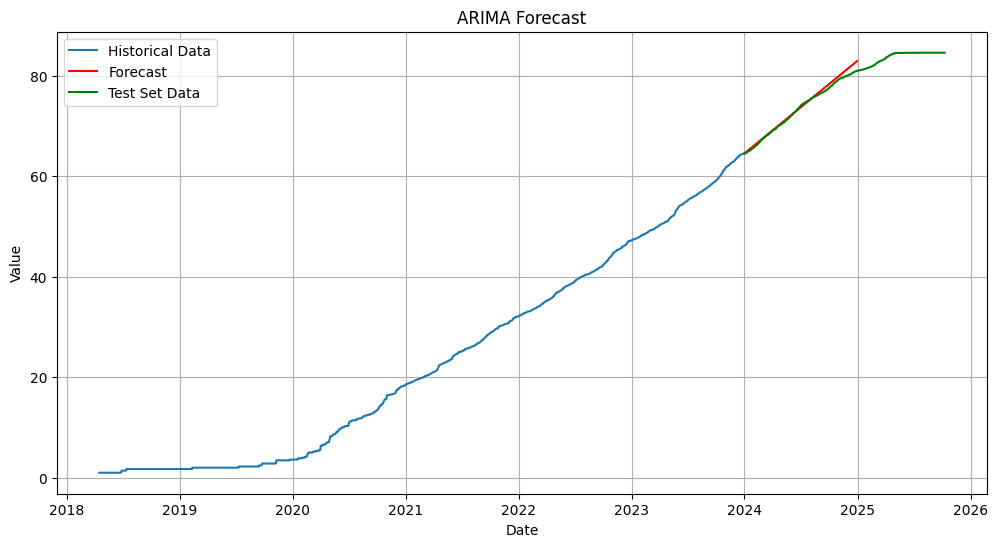

In [6]:
# Use the optimal order found by auto_arima to predict the time series from 01.01.2024 to 01.01.2025
from datetime import date
# 3. Fit ARIMA Model
model = ARIMA(df['value'], order=(2,2,1))
model_fit = model.fit()
print(model_fit.summary())
# 4. Forecast
forecast = model_fit.forecast(steps=365)  # Forecast for the next 365 days
forecast_index = pd.date_range(start=train_set_max_date, periods=365, freq='D')
forecast_series = pd.Series(forecast)
forecast_series.index = forecast_index

# test set data for comparison

# 4.1 Plot the forecast



# 5. Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df['value'], label='Historical Data')
plt.plot(forecast_series, label='Forecast', color='red')
plt.plot(test_set_timeseries_index, test_set_timeseries_data, label='Test Set Data', color='green')
plt.ylim = (min(df['value']-10), max(df['value']))
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

